## Impact of dataset resolution on MHW detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo


import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [3]:
import dask, dask_jobqueue 
import dask.distributed as dask_distributed

cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


In [5]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13958536      base dask-wor smomw379  R       0:32      1 nesh-clk588


In [6]:
client

<Client: 'tcp://172.18.4.23:34499' processes=4 threads=32, memory=74.52 GiB>

## load files

In [7]:
## load mask: nest
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'1_atlantic_mask_3D.nc').squeeze()
land_mask = mask.tmask.rename({'X':'x','Y':'y','z':'deptht'})

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/1_mesh_mask.nc'
dsM = xr.open_dataset(path).squeeze().rename({'z':'deptht'})

maskV = (land_mask*dsM.tmask)

AV = (dsM.e1t * dsM.e2t).where(maskV == 1).compute()

In [8]:
## load mask: host
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'atlantic_mask_3D.nc').squeeze()
land_maskO = mask.tmask.isel(X=range(750,1250)).rename({'X':'x','Y':'y','z':'deptht'})

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/ORCA025.L46-KFS006-P-V/nemo/suppl/mesh_mask.nc'
dsMO = xr.open_dataset(path).squeeze().isel(x=range(750,1250)).rename({'z':'deptht'})

## only atlantic and mask land values based on native ORCA025 grid
maskO = (land_maskO*dsMO.tmask)
maskO[:,852:,:] = 0 ## remove atlantic points outside nest domain
maskO[:,0:353,:] = 0 

AO = (dsMO.e1t * dsMO.e2t).where(maskO == 1).compute()

In [9]:
def load_stats(EXP, baseline, var):
    path = f'/gxfs_work/geomar/smomw379/DATA/{EXP}/MHW_Detection/ANALYSIS/'
    ds_00 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-00.nc')
    ds_10 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-10.nc')
    ds_23 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-23.nc')
    ds_30 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-30.nc')

    return ds_00, ds_10, ds_23, ds_30

def load_stats_NEST(EXP, baseline, var):
    path = f'/gxfs_work/geomar/smomw379/DATA/{EXP}/MHW_Detection/ANALYSIS/'
    ds_00 = xr.open_dataset(path+f'1_{EXP}_1y_19800101_20221231_{var}-{baseline}-00.nc')
    ds_10 = xr.open_dataset(path+f'1_{EXP}_1y_19800101_20221231_{var}-{baseline}-10.nc')
    ds_23 = xr.open_dataset(path+f'1_{EXP}_1y_19800101_20221231_{var}-{baseline}-23.nc')
    ds_30 = xr.open_dataset(path+f'1_{EXP}_1y_19800101_20221231_{var}-{baseline}-30.nc')

    return ds_00, ds_10, ds_23, ds_30

In [10]:
## VIKING20X - BASE 
# cycle 1
dsB1_D_00, dsB1_D_10, dsB1_D_23, dsB1_D_30 = load_stats('VIKING20X.L46-KFS003', 'detrend', 'MHW-days')

# cycle 6
dsB6_D_00, dsB6_D_10, dsB6_D_23, dsB6_D_30 = load_stats('VIKING20X.L46-KFS003-6th', 'detrend', 'MHW-days')


In [11]:
## VIKING20X - NEST 
# cycle 1
dsV1_D_00, dsV1_D_10, dsV1_D_23, dsV1_D_30 = load_stats_NEST('VIKING20X.L46-KFS003', 'detrend', 'MHW-days')

# cycle 6
dsV6_D_00, dsV6_D_10, dsV6_D_23, dsV6_D_30 = load_stats_NEST('VIKING20X.L46-KFS003-6th', 'detrend', 'MHW-days')


In [12]:
## define time axis
time = np.arange(1980,2023)

## all-Atlantic

In [14]:
def area_average_D(dsD, A):
    ## area average: weigh by grid cell area so that subpolar latitudes have no larger contribution as there are more, but smaller grid points
    ## ignore grid points where no heatwaves occured for event based averages (duration, intensity)
    ## don't ignore them for grid point based averages (MHW days per year and Events per year)

    Area_averageD =  (dsD * A).sum(('x','y')) / A.sum(('x','y'))

    return Area_averageD

In [15]:
## surface

MHW_domain_B1_00 = area_average_D(dsB1_D_00.N_MHW_days, AO.isel(deptht=0))
MHW_domain_B6_00 = area_average_D(dsB6_D_00.N_MHW_days, AO.isel(deptht=0))

MHW_domain_V1_00 = area_average_D(dsV1_D_00.N_MHW_days, AV.isel(deptht=0)) 
MHW_domain_V6_00 = area_average_D(dsV6_D_00.N_MHW_days, AV.isel(deptht=0)) 

In [16]:
## 100 m 
MHW_domain_B1_10 = area_average_D(dsB1_D_10.N_MHW_days, AO.isel(deptht=10))
MHW_domain_B6_10 = area_average_D(dsB6_D_10.N_MHW_days, AO.isel(deptht=10))

MHW_domain_V1_10 = area_average_D(dsV1_D_10.N_MHW_days, AV.isel(deptht=10)) 
MHW_domain_V6_10 = area_average_D(dsV6_D_10.N_MHW_days, AV.isel(deptht=10)) 

In [17]:
## 1000 m 
MHW_domain_B1_23 = area_average_D(dsB1_D_23.N_MHW_days, AO.isel(deptht=23))
MHW_domain_B6_23 = area_average_D(dsB6_D_23.N_MHW_days, AO.isel(deptht=23))

MHW_domain_V1_23 = area_average_D(dsV1_D_23.N_MHW_days, AV.isel(deptht=23)) 
MHW_domain_V6_23 = area_average_D(dsV6_D_23.N_MHW_days, AV.isel(deptht=23)) 

In [18]:
## 2200 m 
MHW_domain_B1_30 = area_average_D(dsB1_D_30.N_MHW_days, AO.isel(deptht=30))
MHW_domain_B6_30 = area_average_D(dsB6_D_30.N_MHW_days, AO.isel(deptht=30))

MHW_domain_V1_30 = area_average_D(dsV1_D_30.N_MHW_days, AV.isel(deptht=30)) 
MHW_domain_V6_30 = area_average_D(dsV6_D_30.N_MHW_days, AV.isel(deptht=30)) 

## Maps

In [19]:
lonV=dsV6_D_00.nav_lon
latV=dsV6_D_00.nav_lat
lonO=dsB6_D_00.nav_lon
latO=dsB6_D_00.nav_lat

In [20]:
dsV6_00_map = np.ma.masked_equal(dsV6_D_00.N_MHW_days.mean('time') *  maskV.isel(deptht=0),0)
dsV6_23_map = np.ma.masked_equal(dsV6_D_23.N_MHW_days.mean('time') *  maskV.isel(deptht=23),0)

dsB6_00_map = np.ma.masked_equal(dsB6_D_00.N_MHW_days.mean('time') *  maskO.isel(deptht=0),0)
dsB6_23_map = np.ma.masked_equal(dsB6_D_23.N_MHW_days.mean('time') *  maskO.isel(deptht=23),0)

## Plotting

In [21]:
coastline = cft.GSHHSFeature(scale='intermediate')

def plot_cartopy(ax, xticks, yticks, continents=True):
    '''Add cartopy features to the map'''
    if continents:
       ax.add_feature(coastline, edgecolor='darkgrey', facecolor='darkgrey', zorder=100)

    ## add labels
    ax.set_xticks(xticks, crs = ccrs.PlateCarree())
    ax.set_yticks(yticks, crs = ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

/tmp/ipykernel_403520/37895159.py:50: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(ctf_00, ax=[ax4,ax5], orientation='horizontal', shrink=0.7, extend='both', pad=0.04, aspect=30)


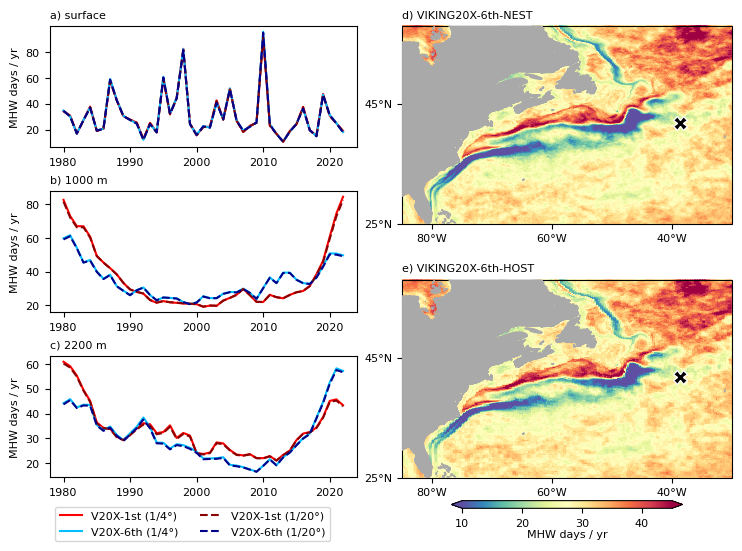

In [30]:
fig = plt.figure(figsize=(7.5,5.5))
ax1 = fig.add_axes([0.08,0.72,0.41,0.22])
ax2 = fig.add_axes([0.08,0.42,0.41,0.22])
ax3 = fig.add_axes([0.08,0.12,0.41,0.22])

ax4 = fig.add_axes([0.55,0.49,0.44,0.48], projection=ccrs.PlateCarree())
ax5 = fig.add_axes([0.55,-0.08,0.44,0.48], projection=ccrs.PlateCarree())


## ATL: surface
ax1.plot(time, MHW_domain_B1_00, color='r', label='V20X-1st (1/4°)')
ax1.plot(time, MHW_domain_B6_00, color='deepskyblue', label='V20X-6th (1/4°)')
ax1.plot(time, MHW_domain_V1_00, color='darkred', linestyle='--', label='V20X-1st (1/20°)')
ax1.plot(time, MHW_domain_V6_00, color='darkblue', linestyle='--', label='V20X-6th (1/20°)')
ax1.set_ylabel('MHW days / yr', fontsize=8)
ax1.set_title('a) surface', loc='left', fontsize=8)
ax1.legend(ncol=2, loc='lower left', bbox_to_anchor=[0,-3.3], fontsize=8)

## ATL: 100m
ax2.plot(time, MHW_domain_B1_23, color='r')
ax2.plot(time, MHW_domain_B6_23, color='deepskyblue')
ax2.plot(time, MHW_domain_V1_23, color='darkred', linestyle='--')
ax2.plot(time, MHW_domain_V6_23, color='darkblue', linestyle='--')
ax2.set_ylabel('MHW days / yr', fontsize=8)
ax2.set_title('b) 1000 m', loc='left', fontsize=8)

## ATL: 1000m
ax3.plot(time, MHW_domain_B1_30, color='r')
ax3.plot(time, MHW_domain_B6_30, color='deepskyblue')
ax3.plot(time, MHW_domain_V1_30, color='darkred', linestyle='--')
ax3.plot(time, MHW_domain_V6_30, color='darkblue', linestyle='--')
ax3.set_ylabel('MHW days / yr', fontsize=8)
ax3.set_title('c) 2200 m', loc='left', fontsize=8)


##
ctf_00 = ax4.pcolor(lonV, latV, dsV6_00_map, vmin=10, vmax=45, cmap='Spectral_r')
ax4.set_extent([-85,-30,25,55])
plot_cartopy(ax4, xticks=np.arange(-80,-30,20), yticks=np.arange(25,51,20))
ax4.set_title('d) VIKING20X-6th-NEST', loc='left', fontsize=8)
ax4.plot(-38.6, 41.8, 'kX', ms=10,mec='w')

##
ax5.pcolor(lonO, latO, dsB6_00_map, vmin=10, vmax=45, cmap='Spectral_r')
ax5.set_extent([-85,-30,25,55])
plot_cartopy(ax5, xticks=np.arange(-80,-30,20), yticks=np.arange(25,51,20))
ax5.set_title('e) VIKING20X-6th-HOST', loc='left', fontsize=8)
ax5.plot(-38.6, 41.8, 'kX', ms=10, mec='w')

cb = plt.colorbar(ctf_00, ax=[ax4,ax5], orientation='horizontal', shrink=0.7, extend='both', pad=0.04, aspect=30)
cb.set_label('MHW days / yr', fontsize=8, labelpad=1)

plt.savefig('Dataset_Resolution.png', dpi=300)

## Save data for publication
* full output (annual mean MHW characteristics) already stored 